# SMS Spam/Ham Classification 

## **Import the necessary libraries**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from wordcloud import WordCloud
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline

## **Exploratory data analysis**

**Load the data into Pandas dataframe**

In [68]:
data = pd.read_csv('spam.csv',encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Drop the columns that are not required for the neural network.**

**Now drop "unnamed" columns and rename v1 and v2 to "label" and "message"**

In [0]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
data = data.rename(columns={'v1':'label' , 'v2':'message'})

**Let's look into data.**

In [70]:
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [72]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

**Understand the distribution better.**

Text(0.5, 1.0, 'Number of ham and spam messages')

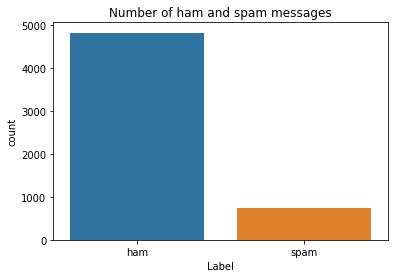

In [73]:
sns.countplot(data.label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

## **Data Preprocessing**

*   **Create input and output vectors.**
*   **Process the labels.**

In [0]:
X = data.message
Y = data.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

**Split into training and test data.**

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15, random_state=42)

**Process the data**
*   **Tokenize the data and convert the text to sequences.**
*   **Add padding to ensure that all the sequences have the same shape.**
*   **There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.**



In [0]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

## **Recurrent Neural Network (RNN)**

**Define the RNN structure.**


In [0]:
def RNN():
    model = Sequential()
    model.add(Embedding(max_words,50,input_length=max_len))
    model.add(LSTM(64))
    model.add(Dense(256,name='hidden_layer',activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1,name='out_layer',activation='sigmoid'))
    return model

In [89]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['accuracy'])

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_87 (Embedding)     (None, 150, 50)           50000     
_________________________________________________________________
lstm_87 (LSTM)               (None, 64)                29440     
_________________________________________________________________
hidden_layer (Dense)         (None, 256)               16640     
_________________________________________________________________
dropout_87 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________


**Fit neural network on training dataset**

In [90]:
#callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)] This can be used to stop training when we achieve our desire result
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=5,validation_split=0.2)

Train on 3788 samples, validate on 948 samples
Epoch 1/5
3788/3788 [==============================] - 32s 8ms/step - loss: 0.6644 - acc: 0.8366 - val_loss: 0.6318 - val_acc: 0.8660
Epoch 2/5
3788/3788 [==============================] - 8s 2ms/step - loss: 0.6052 - acc: 0.8648 - val_loss: 0.5776 - val_acc: 0.8660
Epoch 3/5
3788/3788 [==============================] - 8s 2ms/step - loss: 0.5568 - acc: 0.8648 - val_loss: 0.5348 - val_acc: 0.8660
Epoch 4/5
3788/3788 [==============================] - 8s 2ms/step - loss: 0.5190 - acc: 0.8648 - val_loss: 0.5016 - val_acc: 0.8660
Epoch 5/5
3788/3788 [==============================] - 8s 2ms/step - loss: 0.4895 - acc: 0.8648 - val_loss: 0.4759 - val_acc: 0.8660


**Convert into category**

In [0]:
def category(y_pred):
  yli_pred = []
  for i in range(len(y_pred)):
    if y_pred[i]>=0.5:
      yli_pred.append(1)
    else:
      yli_pred.append(0)
  return yli_pred

**Evaluate model**

In [0]:
Y_pred1 = category(model.predict(test_sequences_matrix))

In [93]:
cm1 = confusion_matrix(Y_test,Y_pred1)
df1 = pd.DataFrame(cm1)
df1

,0,1
0,728,0
1,108,0


In [94]:
print(classification_report(Y_test,Y_pred1))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       728
           1       0.00      0.00      0.00       108

    accuracy                           0.87       836
   macro avg       0.44      0.50      0.47       836
weighted avg       0.76      0.87      0.81       836



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [95]:
print(accuracy_score(Y_test,Y_pred1))

0.8708133971291866


## **Hyperparameter Tuning using GridSearchCV**

**I did Hyperparameter tuning using GridSearchCV by taking below parameters.**
*   **activation = [ 'relu', 'tanh', 'softmax']**
*   **optimizer = ['SGD', 'RMSprop', 'Adam']**
*   **dropout_rate = np.linspace(0.1, 0.9, num = 3)**

In [0]:
def RNN_Tune(activation='tanh', dropout_rate=0.1, optimizer='Adam'):
    model1 = Sequential()
    model1.add(Embedding(max_words,50,input_length=max_len))
    model1.add(LSTM(64))
    model1.add(Dense(256,name='hidden_layer',activation=activation))
    model1.add(Dropout(dropout_rate))
    model1.add(Dense(1,name='out_layer',activation='sigmoid'))
    model1.summary()
    model1.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model1

In [0]:
model1 = KerasClassifier(build_fn=RNN_Tune, epochs=5, batch_size=128, verbose=1)

**I took CrossValidation parameter cv = 3 here to decrease processing time. Still it took me more than 60 minutes to run this.**

In [98]:
activation = [ 'relu', 'tanh', 'softmax']
optimizer = ['SGD', 'RMSprop', 'Adam']
dropout_rate = np.linspace(0.1, 0.9, num = 3)
param_grid = dict(activation=activation, dropout_rate=dropout_rate, optimizer=optimizer)
grid = GridSearchCV(estimator=model1, param_grid=param_grid, cv = 3)
grid_result = grid.fit(sequences_matrix, Y_train)

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_88 (Embedding)     (None, 150, 50)           50000     
_________________________________________________________________
lstm_88 (LSTM)               (None, 64)                29440     
_________________________________________________________________
hidden_layer (Dense)         (None, 256)               16640     
_________________________________________________________________
dropout_88 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
3157/3157 [==============================] - 26s 8ms/step - loss: 0.6641 - acc: 0.8657
Epoch 2/5
3157/315

**Get the best parameter and best score.**

In [114]:
print("Best: %f using \n%s" % (grid_result.best_score_, grid_result.best_params_))
print("\n\n")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.986486 using 
{'activation': 'tanh', 'dropout_rate': 0.1, 'optimizer': 'Adam'}



0.865076 (0.001894) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'SGD'}
0.986064 (0.002371) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'RMSprop'}
0.985642 (0.001956) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'Adam'}
0.865076 (0.001894) with: {'activation': 'relu', 'dropout_rate': 0.5, 'optimizer': 'SGD'}
0.986275 (0.002847) with: {'activation': 'relu', 'dropout_rate': 0.5, 'optimizer': 'RMSprop'}
0.985853 (0.002332) with: {'activation': 'relu', 'dropout_rate': 0.5, 'optimizer': 'Adam'}
0.865076 (0.001894) with: {'activation': 'relu', 'dropout_rate': 0.9, 'optimizer': 'SGD'}
0.985642 (0.002154) with: {'activation': 'relu', 'dropout_rate': 0.9, 'optimizer': 'RMSprop'}
0.984797 (0.001864) with: {'activation': 'relu', 'dropout_rate': 0.9, 'optimizer': 'Adam'}
0.865076 (0.001894) with: {'activation': 'tanh', 'dropout_rate': 0.1, 'optimizer': 'S

**Testing**

In [100]:
Y_pred2 = category(grid_result.best_estimator_.predict(test_sequences_matrix))

836/836 [==============================] - 16s 19ms/step


In [101]:
cm2 = confusion_matrix(Y_test,Y_pred2)
df2 = pd.DataFrame(cm2)
df2

,0,1
0,724,4
1,12,96


In [102]:
print(classification_report(Y_test,Y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       728
           1       0.96      0.89      0.92       108

    accuracy                           0.98       836
   macro avg       0.97      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836



In [103]:
print(accuracy_score(Y_test,Y_pred2))

0.9808612440191388


**Confusion Matrix**

In [121]:
print("Confusion matrix before hyperparameter tuning : \n",confusion_matrix(Y_test,Y_pred1))
print("Confusion matrix after hyperparameter tuning : \n",confusion_matrix(Y_test,Y_pred2))

Confusion matrix before hyperparameter tuning : 
 [[728   0]
 [108   0]]
Confusion matrix after hyperparameter tuning : 
 [[724   4]
 [ 12  96]]


## **Misclassified Samples**

In [108]:
j = 0
i = 0
while(i<10):
  if Y_pred2[j] != Y_test[j]:
    print(list(X_test)[j])
    print("Y_test : ",Y_test[j])
    print("Y_pred : ",Y_pred2[j])
    print("\n")
    i = i + 1
  j = j + 1

Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens
Y_test :  [0]
Y_pred :  1


Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom now. text SUE to 89555. By TextOperator G2 1DA 150ppmsg 18+
Y_test :  [1]
Y_pred :  0


ringtoneking 84484
Y_test :  [1]
Y_pred :  0


Urgh, coach hot, smells of chip fat! Thanks again, especially for the duvet (not a predictive text word).
Y_test :  [0]
Y_pred :  1


08714712388 between 10am-7pm Cost 10p
Y_test :  [1]
Y_pred :  0


Can U get 2 phone NOW? I wanna chat 2 set up meet Call me NOW on 09096102316 U can cum here 2moro Luv JANE xx Callså£1/minmoremobsEMSPOBox45PO139WA
Y_test :  [1]
Y_pred :  0


Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123
Y_test :  [1]
Y_pred :  0


Oh. U must have taken your REAL Valentine out shopping first.
Y_test :  [0]
Y_pr